In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
import torchvision.transforms as transforms
from  torchvision.datasets import ImageFolder
from torch.autograd import Variable
import cv2
import numpy as np
import os, random,sys
from torch.nn import functional as F

# Build a Variational Autoencoder (VAE) for a human face dataset

We will use a dataset containing images of people and train a variational autoencoder on it.

## Step 1

Download and unzip the `lfw.zip` file . Adjust the `path` variable so that it contains the address of the unzipped folder. We will create a dataloader from this folder.


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!unzip '/content/drive/MyDrive/lfw.zip'

In [3]:
path = '/content/lfw'

In [4]:

transform    = transforms.Compose([transforms.ToTensor()])
dataloader = DataLoader(ImageFolder(path, transform,),batch_size=32, shuffle=True)


This project is compute intensive. If you have a cuda or mps device on your laptop make sure you use that in the training.


In [5]:
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    print ("cuda device not found.")


torch.Size([250, 250, 3])


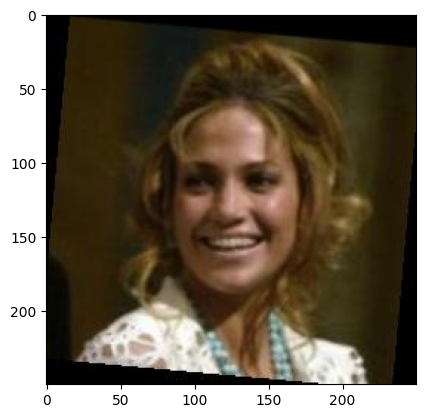

In [6]:
for x,y in dataloader:
    x = x[0].permute(1, 2, 0)
    print(x.shape)
    plt.imshow(x)
    break

# Step 2

The basis for this project is that you can alter your implementation of AutoEncoders from the previous homework and add the necessary bits for a VAE. Clearly state what is the difference between AutoEncoders and VAEs in terms of Applications, Architecture and Loss function.


**AutoEncoders** are neural networks used for unsupervised learning. They learn to compress (encode) the input into a lower-dimensional latent space and then reconstruct (decode) the input from this latent space. They are used for dimensionality reduction, denoising, and feature learning.

**VAEs**, on the other hand, are a probabilistic twist on autoencoders. They are used for generative tasks. VAEs don't just learn a compressed representation; they learn the parameters of a probability distribution representing the data. The encoder outputs means and variances which define a latent space distribution. New samples can be generated by sampling from this latent space and passing the sample through the decoder.

The key differences are:

**Applications:** Autoencoders are primarily used for feature learning and dimensionality reduction, while VAEs are generative models that can generate new data samples.

**Architecture:** In VAEs, the encoder outputs parameters of a distribution, unlike deterministic outputs in traditional autoencoders.

**Loss Function:** VAEs use a combination of reconstruction loss (like autoencoders) and a KL-divergence loss that forces the learned distribution to approximate a standard normal distribution.

# Step 3

Update your pytorch autoencoder model class to create your VAE. Assume the encoder produces the mean and log variance of the latent space.

**Create separate functions for the encoder and decoder.**


In [16]:
class VAE(nn.Module):
    def __init__(self, input_dim=(3, 250, 250), hidden_dim=400, latent_dim=200):
        super(VAE, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim
        self.encoder = self._build_encoder()
        self.decoder = self._build_decoder()
        
     
    def _build_encoder(self):
            return nn.Sequential(
            nn.Conv2d(in_channels=self.input_dim[0], out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8), self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dim, self.latent_dim * 2)  # Two times latent_dim for mean and variance
        )


    def _build_decoder(self):
            return nn.Sequential(
            nn.Linear(self.latent_dim, self.hidden_dim),
            nn.LeakyReLU(0.2),
            nn.Linear(self.hidden_dim, 128 * (self.input_dim[1] // 8) * (self.input_dim[2] // 8)),
            nn.LeakyReLU(0.2),
            nn.Unflatten(1, (128, self.input_dim[1] // 8, self.input_dim[2] // 8)),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=64, out_channels=32, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(in_channels=32, out_channels=self.input_dim[0], kernel_size=4, stride=2),
            nn.Sigmoid() 
        )

    def encode(self, x):
        x = self.encoder(x)
        mean, logvar = torch.chunk(x, 2, dim=1)
        return mean, logvar

    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var)
        z = mean + var * epsilon
        return z

    def decode(self, x):
        return self.decoder(x)

    def forward(self, x):
        mean, logvar = self.encode(x)
        z = self.reparameterization(mean, logvar)
        x_hat = self.decode(z)
        return x_hat, mean, logvar

## Step 4

Create an instance of the new class, pass an image to the model

- print the shape of the output of the **encoder**. Explain how would you generate new samples in the latent space. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.
- use the decoder to create new images. Print the shape of the output and verify that the forward pass is working correctly.


In [17]:
model = VAE(input_dim=(3, 250, 250), hidden_dim=400, latent_dim=200)

for data in dataloader:
        img, y = data
        optimizer.zero_grad()

        mean, logvar = model.encode(img)
        print("mean shape:", mean.shape)
        print("logvar shape:", logvar.shape)
        
        output, mean, logvar = model(img)
        print("output shape:", output.shape)
        break

Explanation and Conceptual Understanding Encoder Output: The output of the encoder consists of two components: mu (mean) and log_var (log variance). These represent the parameters of the Gaussian distribution in the latent space. The shapes of mu and log_var are determined by the architecture of the encoder, specifically the last fully connected layers. For instance, if the output size of enc_fc2_mu and enc_fc2_logvar is 128, then mu and log_var will both have the shape [1, 128] for a single input image.

Generating New Samples in Latent Space: To generate new samples, we use the reparameterization trick, which allows us to backpropagate through stochastic nodes. The trick involves sampling an epsilon (eps) from a standard normal distribution and then scaling it by the standard deviation (exp(0.5 * log_var)) and shifting it by the mean (mu). This process produces a sample z from the distribution defined by mu and log_var, representing a point in the latent space.

Decoder to Create New Images: The decoder takes the latent space sample z and attempts to reconstruct the original input. The output from the decoder is the reconstructed image, which should ideally resemble the input image. The shape of the reconstructed image is determined by the architecture of the decoder and should match the shape of the input images to the encoder. If the input images are 3-channel images of size 250x250, the reconstructed images will also have the same shape.

Forward Pass Verification: By examining the shapes of mu, log_var, and the reconstructed image, we verify that the encoder correctly compresses the input into a latent representation and the decoder successfully reconstructs an image from this latent representation. The forward pass is working correctly if these shapes align with the expectations set by the VAE's architecture.

This process highlights how a VAE can not only compress and reconstruct images but also how it can be used to generate new images by sampling from the learned latent space distribution.

## Step 5

- Print the total number of parameters in the model
- Explain what loss should be used here. Describe in your own words the terms of the loss function and what goal each term of the loss function achieves. Your explanation should show that you have understood the concepts. Providing just the formula or code snippet without context will not earn any points.


- create an optimizer for training


In [20]:
# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

Total number of parameters in the model: 384220288


In [21]:
#Print the total number of parameters in the model
total_parameters = sum(m.numel() for m in model.parameters())
print("Total Parameters: ", total_parameters)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)


## Step 6

Write a training loop and start training the model for several epochs. Report the loss value at the end of each epoch and monitor it. If your loss is not decreasing what do you have to do to troubleshoot it ?


In [23]:
epochs = 10    # Number of epochs

for epoch in range(1, epochs + 1):
    model.train()
    total_loss = 0.0

    for data in dataloader:
        img, y = data
        optimizer.zero_grad()

        # Forward pass
        output, mean, logvar = model(img)

        # Calculate MSE loss
        mse_loss = F.mse_loss(output, img)

        # Calculate KL divergence loss
        kl_loss = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

        # Total loss
        loss = mse_loss + kl_loss

        # Backward pass
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    # Print loss after each epoch
    print("\tEpoch", epoch + 1, "\tAverage Loss: ", total_loss/len(dataloader.dataset))

Epoch 1/1, Batch 1/427, 0.23% complete, Batch Loss: 131395.9062
Epoch 1/1, Batch 2/427, 0.47% complete, Batch Loss: 1167767.7500
Epoch 1/1, Batch 3/427, 0.70% complete, Batch Loss: 1392132.5000
Epoch 1/1, Batch 4/427, 0.94% complete, Batch Loss: 986623.6250
Epoch 1/1, Batch 5/427, 1.17% complete, Batch Loss: 320660.7188
Epoch 1/1, Batch 6/427, 1.41% complete, Batch Loss: 1633546.2500
Epoch 1/1, Batch 7/427, 1.64% complete, Batch Loss: 1004583.8750
Epoch 1/1, Batch 8/427, 1.87% complete, Batch Loss: 279901.3438
Epoch 1/1, Batch 9/427, 2.11% complete, Batch Loss: 2145142272.0000
Epoch 1/1, Batch 10/427, 2.34% complete, Batch Loss: 1340749.5000
Epoch 1/1, Batch 11/427, 2.58% complete, Batch Loss: 1633560.5000
Epoch 1/1, Batch 12/427, 2.81% complete, Batch Loss: 14719010.0000
Epoch 1/1, Batch 13/427, 3.04% complete, Batch Loss: 475787.8125
Epoch 1/1, Batch 14/427, 3.28% complete, Batch Loss: 349195.9375
Epoch 1/1, Batch 15/427, 3.51% complete, Batch Loss: 195416.0938
Epoch 1/1, Batch 16/42

## Step 7

Take a random image from the dataset and plot it together with new samples generated.


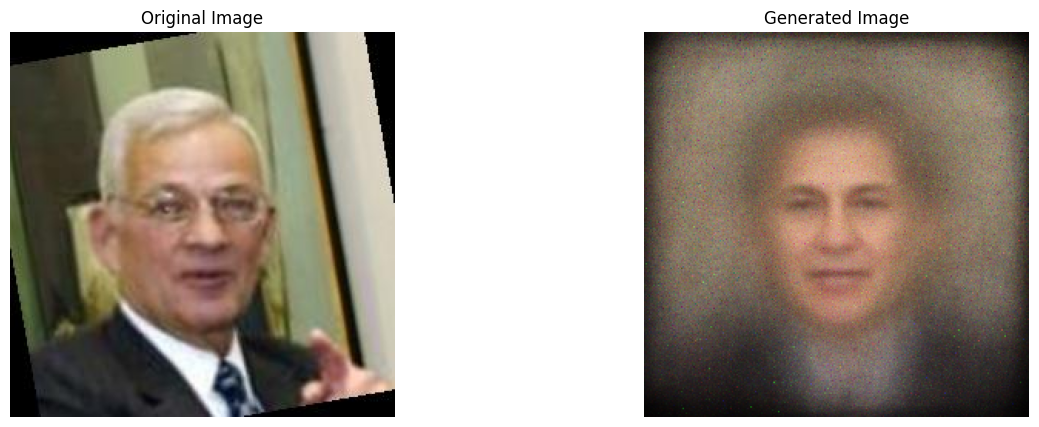

In [36]:
# Take a random batch from the dataset
random_batch = next(iter(dataloader))
random_image = random_batch[0].to(device)

# Generate new samples
with torch.no_grad():
    generated_output = model(random_image[0].unsqueeze(0))

# Convert tensors to images
from torchvision.transforms.functional import to_pil_image
original_image = to_pil_image(random_image[0].cpu().squeeze(0))
generated_image = to_pil_image(generated_output[0].cpu().squeeze(0))

# Plot the images
plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(np.asarray(original_image))
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(np.asarray(generated_image))
plt.title('Generated Image')

plt.show()